In [1]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

In [2]:
def find_faces(img):
    dets = detector(img, 1)

    if len(dets) == 0:
        return np.empty(0), np.empty(0), np.empty(0)
    
    rects, shapes = [], []
    shapes_np = np.zeros((len(dets), 68, 2), dtype=np.int)
    for k, d in enumerate(dets):
        rect = ((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)

        shape = sp(img, d)
        
        # convert dlib shape to numpy array
        for i in range(0, 68):
            shapes_np[k][i] = (shape.part(i).x, shape.part(i).y)

        shapes.append(shape)
        
    return rects, shapes, shapes_np

def encode_faces(img, shapes):
    face_descriptors = []
    for shape in shapes:
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))

    return np.array(face_descriptors)


# Compute Saved Face Descriptions

In [5]:
img_paths = {
    'Koo Tae Wan_1': 'img/koo1.jpg',
    'Koo Tae Wan_2': 'img/koo2.jpg',
    'Koo Tae Wan_3': 'img/koo3.jpg',
    'Koo Tae Wan_4': 'img/koo4.jpg',
    'Koo Tae Wan_5': 'img/koo5.jpg'
    # 'Koo Tae Wan_1': 'img/bun1.jpg',
    # 'Koo Tae Wan_2': 'img/bun2.jpg',
    # 'Koo Tae Wan_3': 'img/bun3.jpg',
    # 'Koo Tae Wan_4': 'img/bun4.jpg',
    # 'Koo Tae Wan_5': 'img/bun5.jpg',
}

descs = {
    'Koo Tae Wan_1': None,
    'Koo Tae Wan_2': None,
    'Koo Tae Wan_3': None,
    'Koo Tae Wan_4': None,
    'Koo Tae Wan_5': None
}

for name, img_path in img_paths.items():
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    _, img_shapes, _ = find_faces(img_rgb)
    descs[name] = encode_faces(img_rgb, img_shapes)[0]

np.save('img/descs.npy', descs)
print(descs)

IndexError: index 0 is out of bounds for axis 0 with size 0

# Compute Input

In [4]:
img_bgr = cv2.imread('img/koo.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

rects, shapes, _ = find_faces(img_rgb)
descriptors = encode_faces(img_rgb, shapes)

# Visualize Output

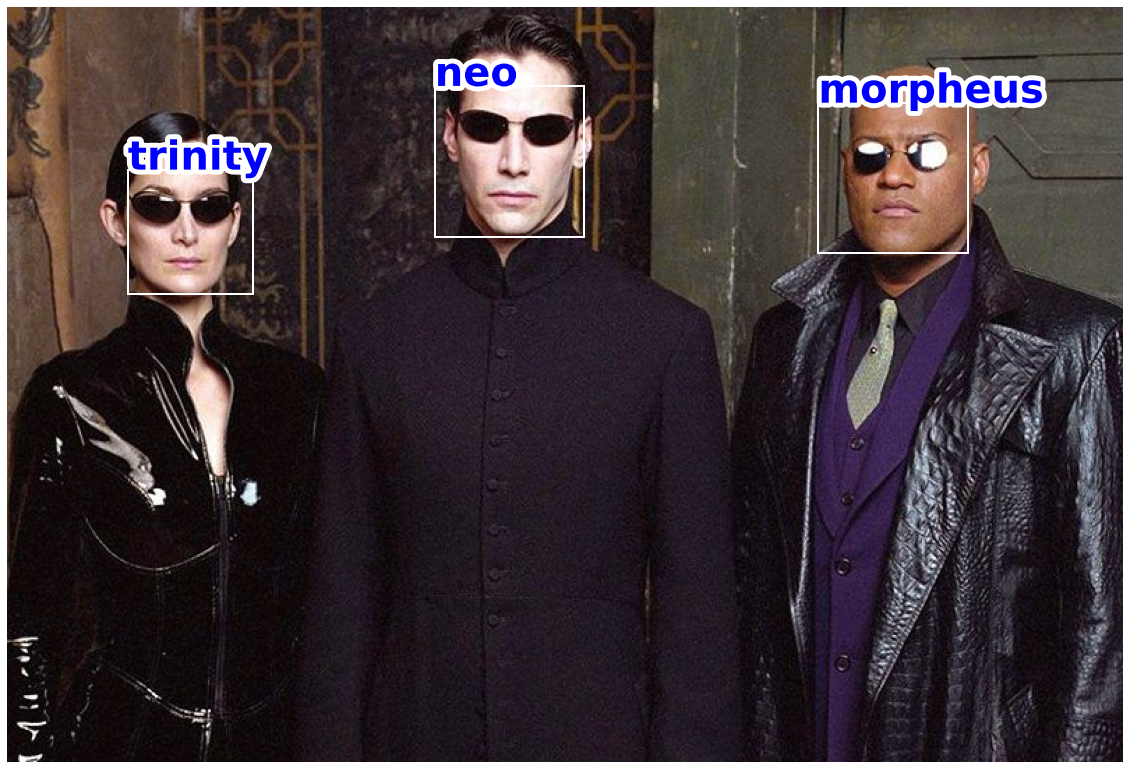

In [5]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(img_rgb)

for i, desc in enumerate(descriptors):
    
    found = False
    for name, saved_desc in descs.items():
        dist = np.linalg.norm([desc] - saved_desc, axis=1)

        if dist < 0.6:
            found = True

            text = ax.text(rects[i][0][0], rects[i][0][1], name,
                    color='b', fontsize=40, fontweight='bold')
            text.set_path_effects([path_effects.Stroke(linewidth=10, foreground='white'), path_effects.Normal()])
            rect = patches.Rectangle(rects[i][0],
                                 rects[i][1][1] - rects[i][0][1],
                                 rects[i][1][0] - rects[i][0][0],
                                 linewidth=2, edgecolor='w', facecolor='none')
            ax.add_patch(rect)

            break
    
    if not found:
        ax.text(rects[i][0][0], rects[i][0][1], 'unknown',
                color='r', fontsize=20, fontweight='bold')
        rect = patches.Rectangle(rects[i][0],
                             rects[i][1][1] - rects[i][0][1],
                             rects[i][1][0] - rects[i][0][0],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.savefig('result/output.png')
plt.show()